<a href="https://colab.research.google.com/github/jumbokh/ML-Class/blob/main/notebooks/CH14Customer_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('IBM_Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


####　資料為 空白 , 無法轉換資料

In [3]:
pd.to_numeric(df['TotalCharges'])

ValueError: ignored

In [4]:
for idx, d in enumerate(df['TotalCharges']):
    try:
        float(d)
    except:
        print(f'problem data {d} at index {idx}')

problem data   at index 488
problem data   at index 753
problem data   at index 936
problem data   at index 1082
problem data   at index 1340
problem data   at index 3331
problem data   at index 3826
problem data   at index 4380
problem data   at index 5218
problem data   at index 6670
problem data   at index 6754


#### 查看資料位置為空白的整筆資料

In [5]:
df.query('TotalCharges == " "').head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No


#### 將 TotalCharges 為空白的資料設為 0
#### 並轉換成浮點數

In [6]:
df['TotalCharges'] = df['TotalCharges'].replace(' ',0)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

#### 14.7 觀察目標欄位 Churn 分布

In [7]:
size = df['Churn'].value_counts()
pct = df['Churn'].value_counts(normalize=True).round(2)
pd.DataFrame(zip(size, pct), columns=['次數', '百分比'], index=['No','Yes'])

,次數,百分比
No,5174,0.73
Yes,1869,0.27


#### No: 樣本裡的 No 即沒有流失顧客佔大多數

#### 14.8 將Churn欄位的No設為0,Yes設為1

In [8]:
df['Churn'] = df['Churn'].replace({'No':0, 'Yes':1})
df.drop('customerID', axis=1, inplace=True)
df_orig = df.copy()

### 14-2 資料探索
#### 14-9 用pairplot來做圖, 並將hue設為目標變數Churn

#### 藍色資料為 0, 代表留下來的顧客
#### 橘色資料為 1, 代表離開的顧客
* SeniorCitizen: 年紀大的比較會流失
* tenure: 使用時間較短的比較會離開
* MonthlyChanges: 每月花費較高的比較會離開
* TotalCharges: 總花費比較少的比較會離開

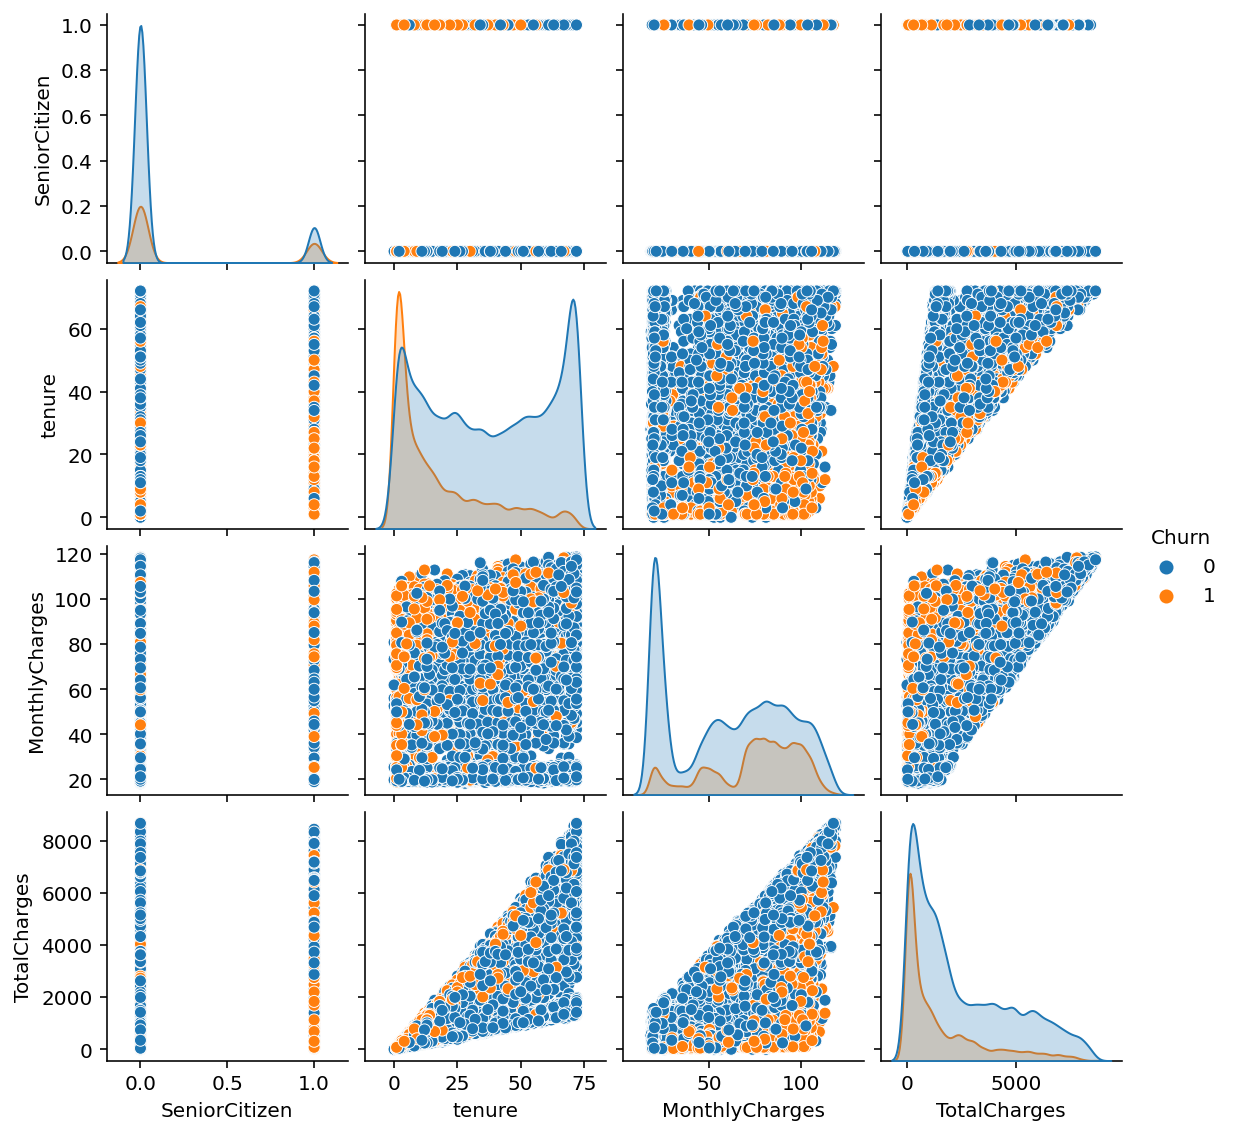

In [9]:
sns.pairplot(df, hue='Churn', size=2, diag_kws=dict(bw=0.1));

#### 檢視所有變數的相關係數
##### TotalCharges:tenure 比較高為 0.83,
    表示總花費與使用年資成高度正相關
##### TotalCharges:MonthlyCharges 為 0.65
    表示總花費較高者, 月花費通常也較高

In [10]:
df.corr().round(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.00,0.02,0.22,0.10,0.15
tenure,0.02,1.00,0.25,0.83,-0.35
MonthlyCharges,0.22,0.25,1.00,0.65,0.19
TotalCharges,0.10,0.83,0.65,1.00,-0.20
Churn,0.15,-0.35,0.19,-0.20,1.00


#### 檢視所有變數和目標變數Churn的關係
* SeniorCitizen: 正相關, 表示年紀大的比較會離開
* tenure: 負相關, 表示使用年資愈長者, 愈不會流失
* MonthlyCharges: 正相關, 月花費較高者, 比較會離開
* TotalCharges: 負相關, 總花費高的人, 比較不會流失

In [11]:
df.corrwith(df['Churn']).round(2)

SeniorCitizen     0.15
tenure           -0.35
MonthlyCharges    0.19
TotalCharges     -0.20
Churn             1.00
dtype: float64

#### 14-12 繪出tenure的直方圖

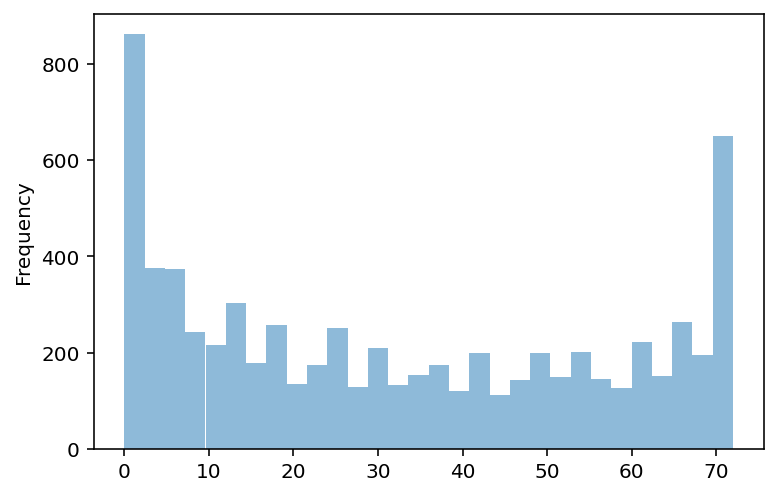

In [12]:
df['tenure'].plot(kind='hist', bins=30, alpha=0.5);

#### 兩端高, 表示沒有使用和使用年資70的族群 人數最多

#### 14-13 檢視男女流失的比例

In [13]:
df.groupby('gender')['Churn'].mean()

gender
Female    0.269209
Male      0.261603
Name: Churn, dtype: float64

#### 結果均為 0.26左右, 表示並無太大差異

### 14-3 資料切割與資料預處理
#### 14-14 資料切割

In [14]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [15]:
X_col_cat = X.select_dtypes(include = 'object').columns
X_col_num = X.select_dtypes(exclude = 'object').columns
print(f'類別型資料欄位：{X_col_cat}')
print(f'數值型資料欄位：{X_col_num}')

類別型資料欄位：Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
數值型資料欄位：Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


#### 檢視類別變數裡的每個類別的出現次數

In [16]:
# 14-16
df[X_col_cat].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
dtype: int64

#### 14-17 建構數值和類別兩個管道器,並整合到合併器

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
data_pl = ColumnTransformer([
    ('num', StandardScaler(), X_col_num),
    ('cat', OneHotEncoder(), X_col_cat)
])

#### 14-18 求出基礎的預測正確率

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
dmy = DummyClassifier(strategy='most_frequent')
dmy.fit(X_train, y_train)
dmy.score(X_train, y_train)
y_pred = dmy.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

正確率： 0.73
混亂矩陣
[[1539    0]
 [ 574    0]]
綜合報告
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1539
           1       0.00      0.00      0.00       574

    accuracy                           0.73      2113
   macro avg       0.36      0.50      0.42      2113
weighted avg       0.53      0.73      0.61      2113



#### 從混亂矩陣來看, 類別1的召回率為0
   預測結果很不好

#### 14-19 用 GridSearchCV 來挑選最佳結果,
      用簡單的機器學習模型

In [19]:
# 載入所有模型
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
# 載作Pipeline，PCA和GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_pl = Pipeline([
    ('preprocess', data_pl),
    ('model', LogisticRegression())
])
param_grid = {'model':[LogisticRegression(), SVC(), 
              KNeighborsClassifier(), DecisionTreeClassifier(max_depth=10)]}
gs = GridSearchCV(model_pl, param_grid=param_grid,
                  cv=5, return_train_score=True)
gs.fit(X_train, y_train)
score = gs.best_estimator_.score(X_test, y_test)
print('最佳預測參數', gs.best_params_)
print('訓練集交叉驗證的最佳結果', gs.best_score_.round(3))
print('測試集的結果', score.round(3))
y_pred = gs.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

最佳預測參數 {'model': LogisticRegression()}
訓練集交叉驗證的最佳結果 0.803
測試集的結果 0.812
[[1387  152]
 [ 245  329]]
綜合報告
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1539
           1       0.68      0.57      0.62       574

    accuracy                           0.81      2113
   macro avg       0.77      0.74      0.75      2113
weighted avg       0.80      0.81      0.81      2113



* 最佳結果是羅吉斯迴歸,
* 測試集結果是 0.81, 比前項預測器好一點
* 從混亂矩陣觀察,並沒有預測偏向類別0的情形
#### 類別1的召回率為 0.57, 表示有四成要離開的顧客找不出來

### 14-4 處理目標樣本不均衡的資料
* 不均衡的目標資料, 指的是流失的顧客是少數
* 在機器學習時,如果已知絕大部分的答案是0, 在不確定答案時,
 會把答案猜為0,這個狀況會讓機器學習無法找出類別個數比較少的樣本

#### 14-20 修改權重

In [20]:
model_pl = Pipeline([
    ('preprocess', data_pl),
    ('model', LogisticRegression())
])
param_grid = {'model':[LogisticRegression(class_weight='balanced'), SVC(class_weight='balanced'), 
DecisionTreeClassifier(class_weight='balanced',max_depth=10)]}
gs = GridSearchCV(model_pl, param_grid=param_grid,
                  cv=5, return_train_score=True)
gs.fit(X_train, y_train)
score = gs.best_estimator_.score(X_test, y_test)
print('最佳預測參數', gs.best_params_)
print('訓練集交叉驗證的最佳結果', gs.best_score_.round(3))
print('測試集的結果', score.round(3))
y_pred = gs.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

最佳預測參數 {'model': SVC(class_weight='balanced')}
訓練集交叉驗證的最佳結果 0.738
測試集的結果 0.754
[[1131  408]
 [ 111  463]]
綜合報告
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1539
           1       0.53      0.81      0.64       574

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.75      0.77      2113



* 最佳結果是羅吉斯迴歸,
* 測試集結果是 0.75 (比原本的0.81下降了不少)

#### 類別1的召回率為 0.81, 表示有兩成要離開的顧客找不出來
#### 比之前的四成要好很多

In [23]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.7/dist-packages (0.8.0)


#### 14-21 向下取樣的抽樣作法說明 
* (將類別比較多的資料重新向下取樣, 使之各數減少)

In [25]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train_resample, y_train_resample = rus.fit_resample(X_train, y_train)
print('原資料的總個數',X_train.shape[0])
print('原本目標值1與0的個數')
print(pd.Series(y_train).value_counts())
print('向下取樣後的總個數',X_train_resample.shape[0])
print('向下取樣後的目標值1與0的個數')
print(pd.Series(y_train_resample).value_counts())

原資料的總個數 4930
原本目標值1與0的個數
0    3635
1    1295
Name: Churn, dtype: int64
向下取樣後的總個數 2590
向下取樣後的目標值1與0的個數
1    1295
0    1295
Name: Churn, dtype: int64


#### 14-22 將向下取樣函數放入預測器裡

In [26]:
# 將Pipeline重新命名為Pipeline_im
from imblearn.pipeline import Pipeline as Pipeline_im
model_pl = Pipeline_im([
    ('preprocess', data_pl),
    ('resample', RandomUnderSampler()),
    ('model', LogisticRegression())
])
param_grid = {'model':[LogisticRegression(), SVC(), 
              KNeighborsClassifier(), DecisionTreeClassifier(max_depth=10)]}
gs = GridSearchCV(model_pl, param_grid=param_grid,
                  cv=5, return_train_score=True)
gs.fit(X_train, y_train)
score = gs.best_estimator_.score(X_test, y_test)
print('最佳預測參數', gs.best_params_)
print('訓練集交叉驗證的最佳結果', gs.best_score_.round(3))
print('測試集的結果', score.round(3))
y_pred = gs.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

最佳預測參數 {'model': LogisticRegression()}
訓練集交叉驗證的最佳結果 0.736
測試集的結果 0.753
[[1107  432]
 [  90  484]]
綜合報告
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1539
           1       0.53      0.84      0.65       574

    accuracy                           0.75      2113
   macro avg       0.73      0.78      0.73      2113
weighted avg       0.82      0.75      0.77      2113



#### 14-23 向上取樣的抽樣作法說明

In [28]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train_upsample, y_train_upsample = smt.fit_resample(data_pl.fit_transform(X_train), y_train)
print('原資料的總個數',X_train.shape[0])
print('原本目標值1與0的個數')
print(pd.Series(y_train).value_counts())
print('向上取樣後的總個數',X_train_upsample.shape[0])
print('向上取樣後的目標值1與0的個數')
print(pd.Series(y_train_upsample).value_counts())

原資料的總個數 4930
原本目標值1與0的個數
0    3635
1    1295
Name: Churn, dtype: int64
向上取樣後的總個數 7270
向上取樣後的目標值1與0的個數
1    3635
0    3635
Name: Churn, dtype: int64


#### 14-24 最常犯的向上取樣錯誤

In [30]:
X_upsample, y_upsample = smt.fit_resample(data_pl.fit_transform(X), y)
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_upsample, 
                                                                y_upsample, test_size=0.3)
# 固定隨機亂數的起點，讓我們的結果會一致
np.random.seed(42)

lr = LogisticRegression()
lr.fit(X_train_up, y_train_up)
y_pred_up = lr.predict(X_test_up)
print('正確率')
print(accuracy_score(y_test_up, y_pred_up))
print('混亂矩陣')
print(confusion_matrix(y_test_up, y_pred_up))
print('綜合報告')
print(classification_report(y_test_up, y_pred_up))

正確率
0.7819645732689211
混亂矩陣
[[1170  398]
 [ 279 1258]]
綜合報告
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1568
           1       0.76      0.82      0.79      1537

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105



* 先做向上取樣後再做資料切割, 同一份資料可能出現在測試集和訓練集
* 所以先切割, 再取訓練集做向上取樣,
* 再用測試集來看結果

In [31]:
# 14-25 向上取樣的正確作法
model_pl = Pipeline_im([
    ('preprocess', data_pl),
    ('resample', SMOTE()),
    ('model', LogisticRegression())
])
param_grid = {'model':[LogisticRegression(), SVC(), 
              KNeighborsClassifier(), DecisionTreeClassifier()]}
np.random.seed(42)
gs = GridSearchCV(model_pl, param_grid=param_grid,
                  cv=5, return_train_score=True)
gs.fit(X_train, y_train)
score = gs.best_estimator_.score(X_test, y_test)
print('最佳預測參數', gs.best_params_)
print('訓練集交叉驗證的最佳結果', gs.best_score_.round(3))
print('測試集的結果', score.round(3))
y_pred = gs.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

最佳預測參數 {'model': SVC()}
訓練集交叉驗證的最佳結果 0.759
測試集的結果 0.767
[[1194  345]
 [ 147  427]]
綜合報告
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1539
           1       0.55      0.74      0.63       574

    accuracy                           0.77      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.77      0.78      2113



* 觀察發現, 正確率為0.77, 但是召回率為0.74, 反而比較差

#### 14-26 ROC圖
* [ROC曲線 wiki](https://zh.wikipedia.org/wiki/ROC%E6%9B%B2%E7%BA%BF)

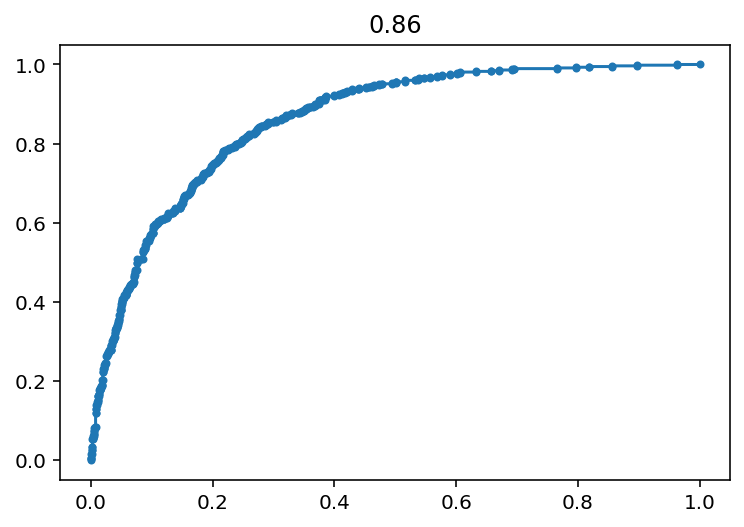

In [32]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
model_pl = make_pipeline(data_pl, LogisticRegression(class_weight='balanced')) 
model_pl.fit(X_train, y_train)
y_pred_proba = model_pl.predict_proba(X_test)[:,1]
fpr, tpr, thres = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr) 
roc_auc
plt.plot(fpr, tpr, marker='.')
plt.title(roc_auc.round(2));

#### PRC圖
* [深入介紹及比較ROC曲線及PR曲線](https://medium.com/nlp-tsupei/roc-pr-%E6%9B%B2%E7%B7%9A-f3faa2231b8c)

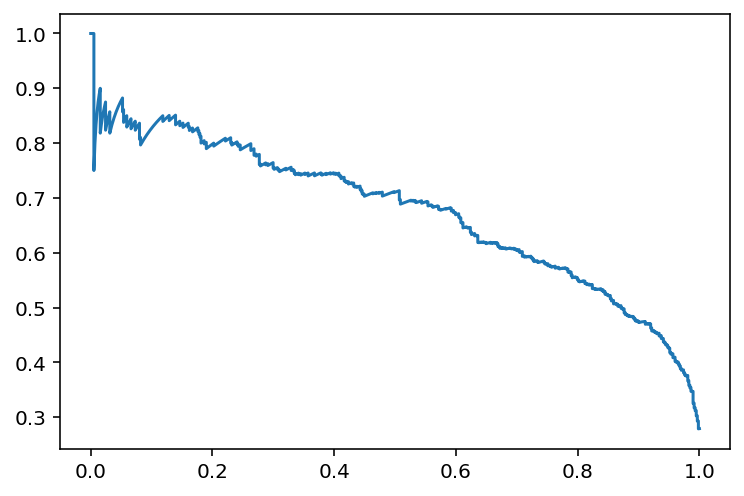

In [33]:
from sklearn.metrics import precision_recall_curve
model_pl = make_pipeline(data_pl, LogisticRegression(class_weight='balanced')) 
model_pl.fit(X_train, y_train)
y_pred_proba = model_pl.predict_proba(X_test)[:,1]
prec, recall, thres = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, prec)

* HomeWork
#### 請用本章資料, 並用向下取樣法,
#### 再用網格搜尋來進行機器學習的挑選
<pre>
'model':[RandomForestClassifier(), AdaBoostClassifier(),
BaggingClassifier(), XGBClassifier()]